# Explore here

In [1]:
# Paso 1: Cargar datos
import pandas as pd
url = 'https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
df = pd.read_csv(url)
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


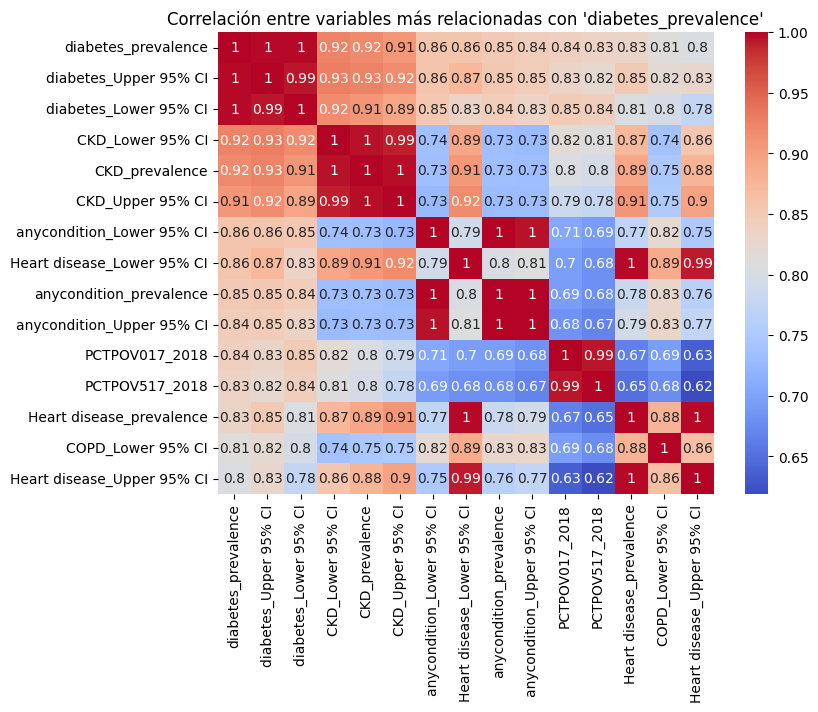

In [2]:
# Paso 2: EDA básico y selección de variable objetivo
import seaborn as sns
import matplotlib.pyplot as plt

target = 'diabetes_prevalence'
df_clean = df.select_dtypes(include=['float64', 'int64']).drop(columns=['fips'], errors='ignore')
df_clean = df_clean.dropna(subset=[target])

correlations = df_clean.corr()[[target]].sort_values(by=target, ascending=False)
top_corr = correlations.abs().sort_values(by=target, ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.heatmap(df_clean[top_corr.index].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables más relacionadas con 'diabetes_prevalence'")
plt.show()

In [3]:
# Paso 3: Modelos de regresión lineal y Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

cols_to_drop = [col for col in df_clean.columns if 'Upper' in col or 'Lower' in col]
df_model = df_clean.drop(columns=cols_to_drop)

X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

lasso_model = Lasso(alpha=1.0, max_iter=10000)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print('Regresión Lineal R2:', r2_score(y_test, y_pred_lr))
print('Lasso R2:', r2_score(y_test, y_pred_lasso))

Regresión Lineal R2: 0.9696177959318519
Lasso R2: 0.8873838835511485


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e+03, tolerance: 1.823e+00
  model = cd_fast.enet_coordinate_descent(


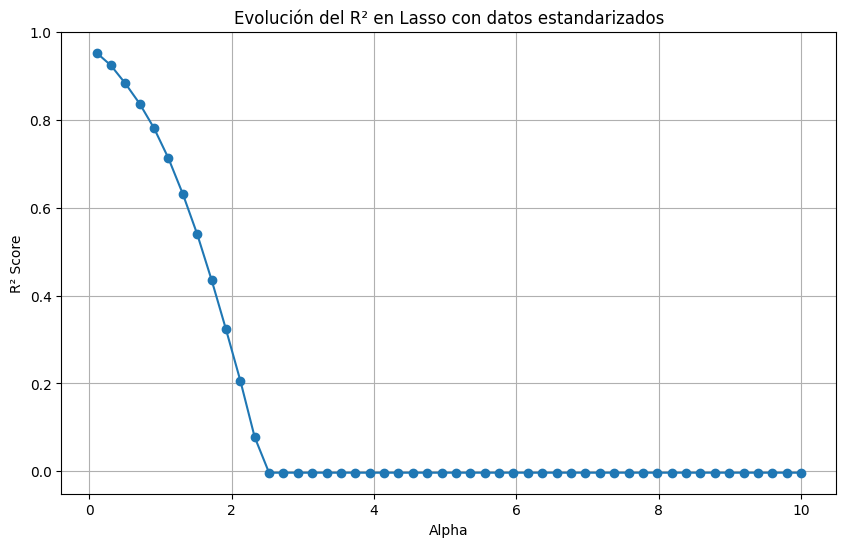

In [4]:
# Paso 4: Evaluar R² con diferentes valores de alpha
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_s, X_test_s, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas = np.linspace(0.1, 10, 50)
r2_scores = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_s, y_train)
    r2_scores.append(r2_score(y_test, lasso.predict(X_test_s)))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(alphas, r2_scores, marker='o')
plt.title("Evolución del R² en Lasso con datos estandarizados")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()

In [5]:
# Paso 5: Optimización con LassoCV
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=np.linspace(0.1, 10, 100), cv=5, max_iter=10000)
lasso_cv.fit(X_train_s, y_train)

y_pred_cv = lasso_cv.predict(X_test_s)
print('Mejor alpha:', lasso_cv.alpha_)
print('R2:', r2_score(y_test, y_pred_cv))
print('MSE:', mean_squared_error(y_test, y_pred_cv))

Mejor alpha: 0.1
R2: 0.9527655258349721
MSE: 0.37991405314949855


In [6]:
# Paso 6: Variables seleccionadas por Lasso
import pandas as pd
selected_features = pd.Series(lasso_cv.coef_, index=X.columns)
selected_nonzero = selected_features[selected_features != 0]
selected_nonzero_sorted = selected_nonzero.reindex(selected_nonzero.abs().sort_values(ascending=False).index)
print(selected_nonzero_sorted)

CKD_prevalence                                                                   1.431928
anycondition_prevalence                                                          0.666165
Percent of adults with less than a high school diploma 2014-18                   0.241935
% Black-alone                                                                    0.221338
COPD_prevalence                                                                  0.179788
Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)   -0.123813
Percent of adults completing some college or associate's degree 2014-18         -0.109242
% White-alone                                                                   -0.097556
PCTPOV517_2018                                                                   0.063952
40-49 y/o % of total pop                                                         0.004022
dtype: float64


##Interpretación de variables seleccionadas por Lasso

Variable	                                                     Coeficiente	                                    Interpretación
CKD_prevalence	                                                    +1.43	                            Más enfermedad renal ⇒ más diabetes.
anycondition_prevalence	                                            +0.67	                            Más condiciones crónicas ⇒ más diabetes.
% sin secundaria	                                                +0.24	                            Bajo nivel educativo ⇒ más diabetes.
% población negra	                                                +0.22	                            Factores demográficos relacionados.
% adultos con estudios universitarios	                            –0.11	                            Más educación ⇒ menos diabetes.
médicos por cada 100k personas	                                    –0.12	                            Más médicos ⇒ mejor prevención.